# Flow past an airfoil

In [1]:
using MAE150A

┌ Info: Recompiling stale cache file /Users/jeff/.julia/compiled/v1.2/MAE150A/A9IAL.ji for MAE150A [a017625c-406c-46ee-99d6-0fac6062339e]
└ @ Base loading.jl:1240


In [2]:
#pyplot()
#clibrary(:colorbrewer)
#default(grid = false)

In [3]:
#using OrdinaryDiffEq

### Solve flow past a stationary body

Set the flow parameters

In [2]:
Re = 1000; # Reynolds number
U = 1.0; # Free stream velocity
U∞ = (U,0.0);

Set up an airfoil

In [3]:
n = 92;
body = Bodies.NACA4(0.04,0.4,0.12,np=n)

NACA 4-digit airfoil with 183 points and length 1.0 and thickness 0.12
   Current position: (0.0,0.0)
   Current angle (rad): 0.0


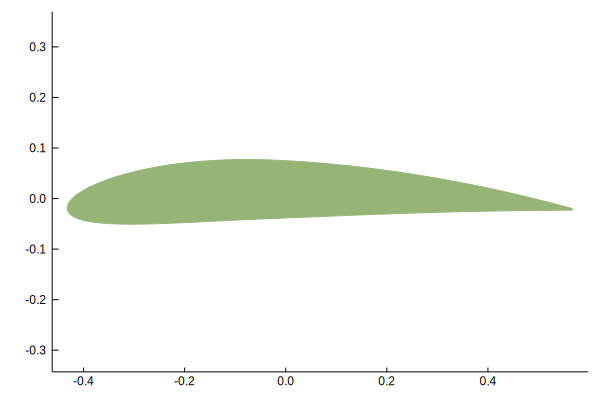

In [4]:
plot(body)

Transform the body with a specified initial position and orientation.

In [5]:
cent = (0.0,0.0) #1.0+1.0im
α = -5π/180 #-π/3 #-π/4
T = RigidTransform(cent,α)
T(body) # transform the body to the current configuration

NACA 4-digit airfoil with 183 points and length 1.0 and thickness 0.12
   Current position: (0.0,0.0)
   Current angle (rad): -0.08726646259971647


Set up the domain

In [6]:
xlim = (-1.0,4.0)
ylim = (-1.0,1.0)

(-1.0, 1.0)

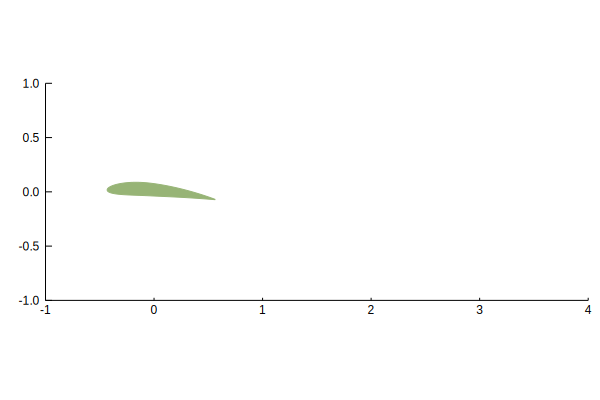

In [7]:
plot(body,xlim=xlim,ylim=ylim)

Now set up the coordinate data for operator construction

In [8]:
X = VectorData(body.x,body.y);

Set the domain size and time step size

In [9]:
Δx = 0.01;
Δt = min(0.5*Δx,0.5*Δx^2*Re);

### Now set up the system

Set up the state vector and constraint force vector for a static body

In [10]:
sys = NavierStokes(Re,Δx,xlim,ylim,Δt,U∞ = U∞, X̃ = X, isstore = true)

Navier-Stokes system on a grid of size 504 x 208

In [11]:
w₀ = Nodes(Dual,size(sys));
f = VectorData(X);
xg, yg = coordinates(w₀,sys.grid)

(-1.0150000000000001:0.01:4.015, -1.035:0.01:1.035)

Set up the integrator here

In [12]:
plan_intfact(t,u) = Systems.plan_intfact(t,u,sys)
plan_constraints(u,t) = TimeMarching.plan_constraints(u,t,sys)
r₁(u,t) = TimeMarching.r₁(u,t,sys)
r₂(u,t) = TimeMarching.r₂(u,t,sys)


@time solver = IFHERK(w₀,f,sys.Δt,plan_intfact,plan_constraints,(r₁,r₂),rk=TimeMarching.RK31,isstored=true)

 14.769415 seconds (18.50 M allocations: 5.222 GiB, 7.14% gc time)


Order-3 IF-HERK integrator with
   State of type Nodes{Dual,504,208,Float64}
   Force of type VectorData{183,Float64}
   Time step size 0.005


Initialize the state vector and the history vectors

In [13]:
t = 0.0
w₀ .= 0.0
u = deepcopy(w₀)
nothing

### Advance the system!

Set the time range to integrate over.

In [14]:
tf = 6.0;
T = Δt:Δt:tf;

In [15]:
fx = Float64[];
fy = Float64[];
thist = Float64[];

tmin_store = 0.0
tmax_store = 100.0
tsample = 0.1
S = StorePlan(tmin_store,tmax_store,tsample,u,t,htype=RegularHistory)
data_history = initialize_storage(S)
nothing

In [16]:
for ti in T
    global t, u, f = solver(t,u)
    
    store_data!(data_history,t,S,deepcopy(u),t)
    
    push!(thist,t)
    push!(fx,sum(f.u)*Δx^2)
    push!(fy,sum(f.v)*Δx^2)
    #(isapprox(mod(t,tsample),0,atol=1e-6) || isapprox(mod(t,tsample),tsample,atol=1e-6)) ? push!(uhist,deepcopy(u)) : nothing
end
println("solution completed through time t = ",t)

solution completed through time t = 5.999999999999894


In [96]:
filen = "NACA4412_5deg.jld"
R = WritePlan(filen,Δt,["u","t"])

WritePlan("NACA4412_5deg.jld", 0.005, ["u", "t"])

In [98]:
save(t,R,deepcopy(data_history[1][end]),t)

#### Plotting

In [17]:
data = data_history;

In [92]:
iplot = 60; #length(data_history[1]) # index of time step for plotting
ω = vorticity(data_history[1][iplot],sys)
q = velocity(data_history,sys)
q.u .+= sys.U∞[1]
q.v .+= sys.U∞[2]
ψ = streamfunction(data_history[1][iplot],sys) #.+ sys.U∞[1]*yg'
ψ .+= sys.U∞[1]*yg'
nothing

Basic plot

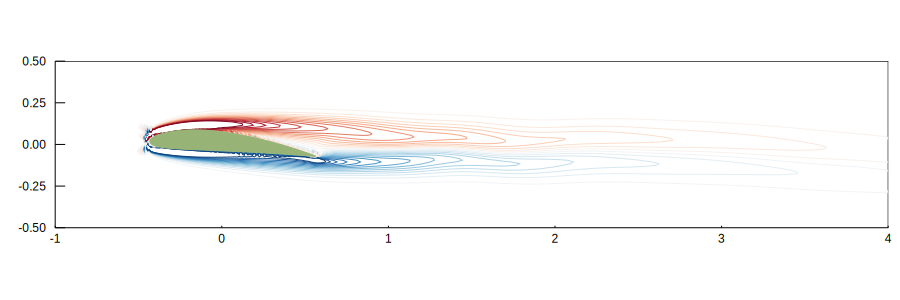

In [95]:
plot(xg,yg,ω,levels=range(-15,15,length=30), color = :RdBu,clim=(-15,15),ylim=(-0.5,0.5),xlim=(-1,4),size=(900,300))
plot!(body)

Streamlines

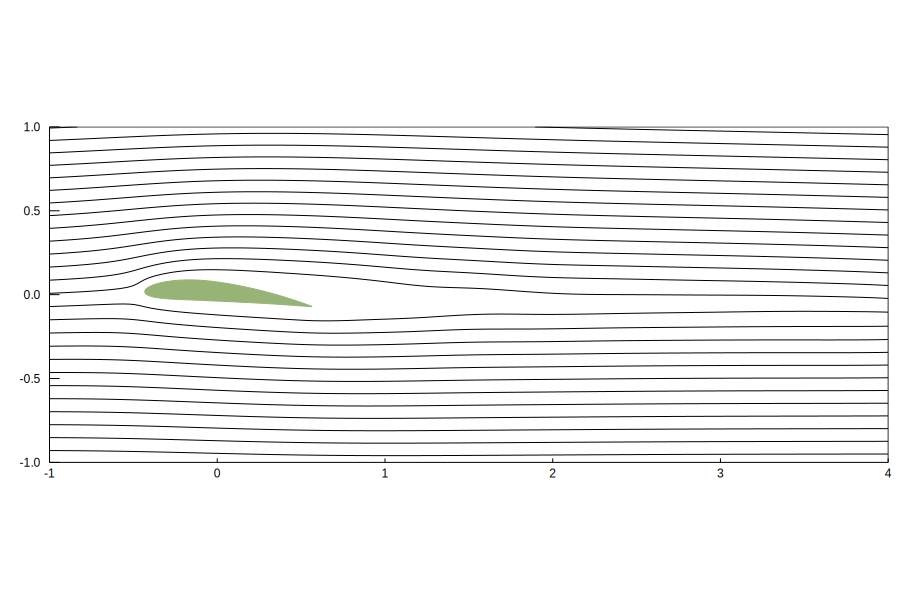

In [77]:
plot(xg,yg,ψ,levels=range(-1,2,length=41), color = :black, ylim = (-1,1),xlim = (-1,4),size=(900,600))
plot!(body)

Plot lift and drag coefficient

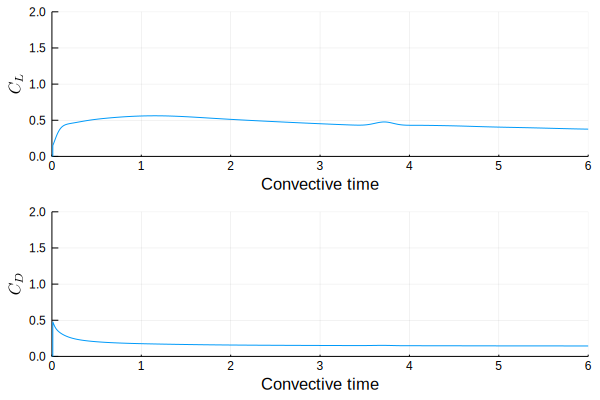

In [35]:
plt = plot(layout = (2,1), size = (600, 400))
plot!(plt[1],thist,2*fy,xlim=(0,6),ylim=(0,2),xlabel="Convective time",ylabel="\$C_L\$",legend=false)
plot!(plt[2],thist,2*fx,xlim=(0,6),ylim=(0,2),xlabel="Convective time",ylabel="\$C_D\$",legend=false)
plt

### Get an interpolatable version of velocity field

In [36]:
ufield, vfield = interpolatable_field(q,sys.grid);

In [37]:
ufield(-1,0.5)

0.9936729632088908

In [38]:
function _vfcn!(dR,R,p,t,u,v)
    dR[1] = u(R[1],R[2])
    dR[2] = v(R[1],R[2])
    
   return dR 
end

vfcn!(dR,R,p,t) = _vfcn!(dR,R,p,t,ufield,vfield)

vfcn! (generic function with 1 method)

In [82]:
using JLD

In [101]:
save("NACA4412_5deg.jld","Re",Re,"U∞",U∞,"Δt",Δt,"grid",sys.grid,"body",body,"u",u)

In [39]:
x0 = [-1.0,0.05]
tspan = (0.0,3.0)
Path = ODEProblem(vfcn!,x0,tspan)
sol = solve(Path,ABM54(), dt = Δt, maxiters = 1e8, adaptive = false, dense = false);

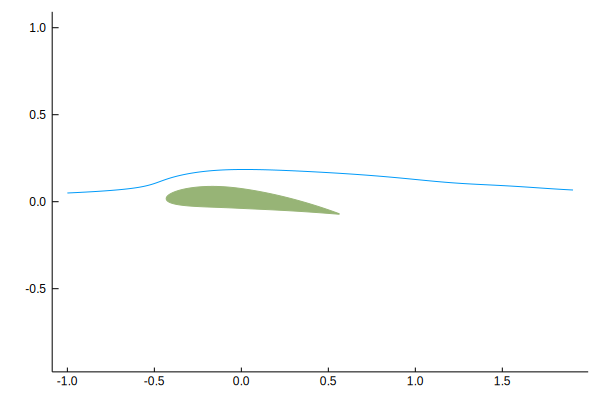

In [40]:
plot(sol[1,:],sol[2,:])
plot!(body)

In [41]:
utraj = []
vtraj = []
for u in sol.u
    push!(utraj,ufield(u...))
    push!(vtraj,vfield(u...))
end

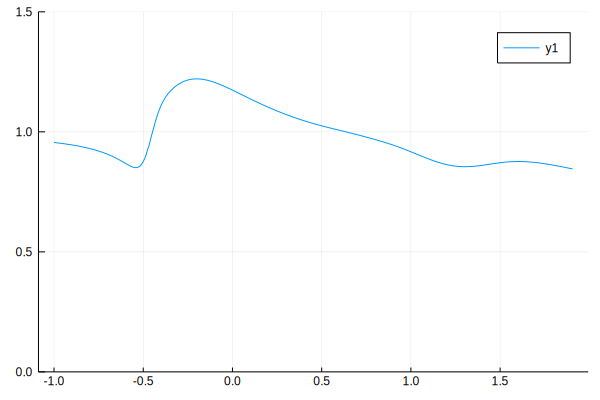

In [43]:
plot(sol[1,:],utraj,ylim=(0,1.5))